## Segmentation Algorithm Demo for Alpha Tubulin

Should we have a little description of tubulin here?
Also, we may add a picture of the corresponding row in the lookup table for readers to correlate this notebook with a specifc row in the lookup table.

In [8]:
import os
import numpy as np

import matplotlib.pyplot as plt                          # package for image preview
from itkwidgets import view                              # package for 3d visualization
from aicsimage import io, processing                     # package for io 
from aicssegmentation.core.visual import img_seg_combine # function for segmentation result inspection
from scipy.ndimage import gaussian_filter                # function for smoothing
from aicssegmentation.core.vessel import vesselness3D    # function for core algorithm
from skimage.morphology import remove_small_objects      # function for post-processing (size filter)

### Folder and file to be analyzed

In [2]:
ROOT_FOLDER_NAME = '/allen/aics/assay-dev/Segmentation/RedTub_Segmentation/pipeline_data'
FILE_NAME = '3500000741_100X_20170324_D04_P04.czi'

### Loading the data

In [3]:
reader = processing.AICSImage(os.path.join(ROOT_FOLDER_NAME,FILE_NAME)) 

IMG = reader.data

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 65, 624, 924)


### Preview of the image

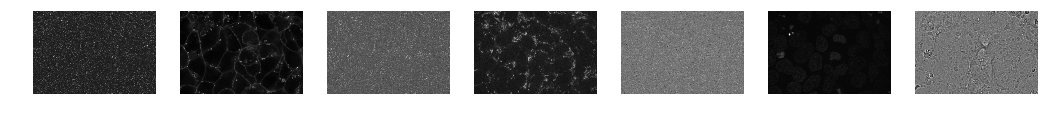

In [4]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(N_CHANNELS):
    ax[channel].axis('off')
    ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

### Image segmentation

#### Step 0: Define Parameters

In [5]:
structure_channel = 1
dynamic_range = 14
gaussian_smoothing_sigma = 1
filament_range = [1,2] # inclusive lower bound, exclusive upper bound
filament_step = 1
filament_threshold_3d = 0.005
minArea = 20

#### Step 1: Pre-Processing

In [6]:
structure_img = IMG[0,structure_channel,:,:,:]

# intensity normalization
max_range = min(np.max(structure_img), np.median(structure_img) + dynamic_range*np.std(structure_img))
structure_img[structure_img>max_range] = max_range
structure_img = (structure_img - structure_img.min() + 1e-8)/(max_range - structure_img.min() + 1e-8)

# smoothing with gaussian filter
structure_img_smooth = gaussian_filter(structure_img, sigma=gaussian_smoothing_sigma, mode='nearest', truncate=3.0)

#### Step 2: Core Algorithm

In [9]:
response = vesselness3D(structure_img_smooth, scale_range=filament_range, scale_step=filament_step,  tau=1, whiteonblack=True)
bw = response > filament_threshold_3d

[1]


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Step 3: Post-Processing 

In [10]:
# size filtering
SEG = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

### Result inspection

In [ ]:
view(img_seg_combine(structure_img,SEG))

In [22]:
view(structure_img)

Viewer(rendered_image=<itkImagePython.itkImageD3; proxy of <Swig Object of type 'itkImageD3 *' at 0x7f45842db6…

In [ ]:
view(SEG.astype(np.uint8))